# Machine Learning Layer
#### Goal: Estimate the next beta

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## 1) Import Data:
CSV file can be found in Teams under Model/ML_for_Beta/all_matrix_data.csv

In [141]:
df = pd.read_csv('../../../../Assets/Data/all_matrix_data.csv', index_col=0)

## 2) Visualize Data:
#### 2.1) Average Infections (training period):

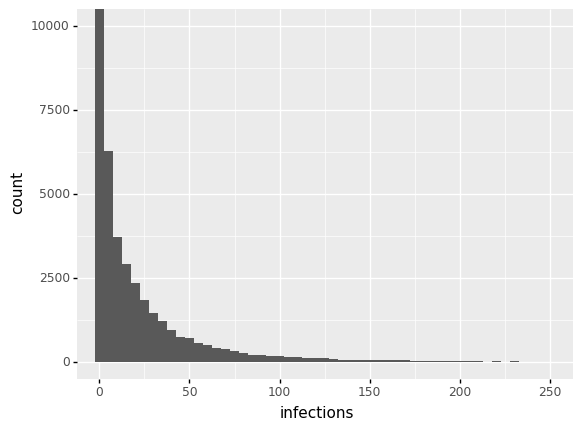

<ggplot: (342034707)>

In [142]:
ggplot(df, aes(x='infections')) + geom_histogram(binwidth=5) + coord_cartesian(xlim=(0,250),ylim=(0,10000))

#### 2.2) Fitted beta:

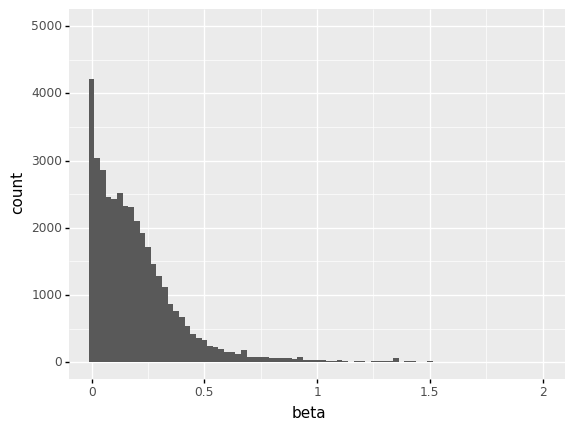

<ggplot: (342119590)>

In [143]:
ggplot(df, aes(x='beta')) + geom_histogram(binwidth=0.025) + coord_cartesian(xlim=(0,2),ylim=(0,5000))

#### 2.3) Average infections Münster

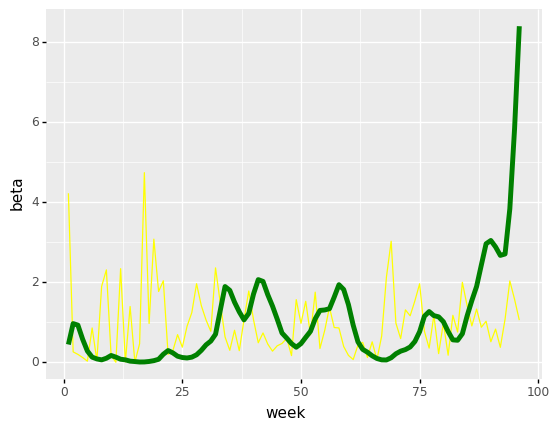

<ggplot: (342170365)>

In [144]:
district = 'Münster'
df_v2_3 = df[df['district']==district][['week','district','infections','beta']]

# Devide both columns by their mean so that they fit in one plot:
df_v2_3['infections'] = df_v2_3['infections']/df_v2_3['infections'].mean()
df_v2_3['beta'] = df_v2_3['beta']/df_v2_3['beta'].mean()

ggplot(df_v2_3) \
+ geom_line(aes(x='week', y='beta'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

#### 2.4) Policy index vs infections: (Germany)

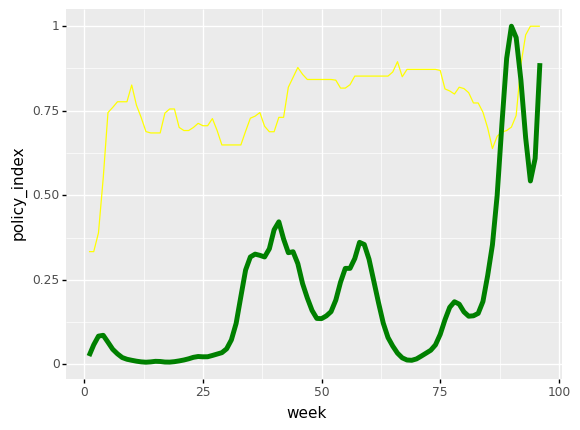

<ggplot: (339038657)>

In [226]:
df_v2_4 = df.groupby('week').sum()

# Devide both columns by their max so that they fit in one plot:
df_v2_4['infections'] = df_v2_4['infections']/df_v2_4['infections'].max()
df_v2_4['policy_index'] = df_v2_4['policy_index']/df_v2_4['policy_index'].max()

ggplot(df_v2_4.reset_index())\
+ geom_line(aes(x='week', y='policy_index'), color='yellow')\
+ geom_line(aes(x='week', y='infections'), color='green', size=2)

## 3) Feature Engineering:
#### Lagged beta:

In [145]:
# Sort values by district and week before lagging:
df.sort_values(['district','week'], inplace=True)

In [146]:
# Get beta of previous weeks:
df['beta_lag_1_week'] = df['beta'].shift(1)

In [147]:
# Drop week 1 as the lagged value is unknown here:
df_v3 = df[df['week']>1]

In [148]:
# Check out correlation between current and previous weeks beta:
df_v3['beta'].corr(df_v3['beta_lag_1_week'] )

-0.005049577608699887

## 4) Data cleaning:
#### Identify missing values:

In [149]:
df_v3.isnull().sum()

week                  0
policy_index          0
variant               0
mobility              0
temperature         256
wind               4004
infections            0
beta                  0
district              0
beta_lag_1_week       0
dtype: int64

#### Fill missing values with previous column:
Forward fill: Fill down (-> if missing value in week 50 use value of week 49)

In [150]:
df_v4 = df_v3.fillna(method='ffill')

## 5) Outlier removal:
#### 5.1) Infection counts:
Remove weeks in which the average number of daily infections where below a threshold as for extremely low values it is really hard to forecast beta:

In [155]:
# Drop all columns in which average number of infections is below 5:
threshold = 5
df_v5_1 = df_v4[df_v4['infections'] > threshold]

#### 5.2) Beta values:

In [156]:
# TO BE IMPLEMENTED

## 6) Preprocessing columns:
#### 6.1) Handling categorical columns:

In [181]:
# Only use week and district as index columns:
df_v6_1 = df_v5_1.set_index(['week','district'])

In [201]:
# One hot-encode variant columns:
df_v6_2_a = pd.get_dummies(df_v6_1['variant'])
df_v6_2_b = df_v6_1.drop(columns='variant', axis=1)

df_v6_2_c = pd.concat([df_v6_2_a,df_v6_2_b], axis=1)

In [202]:
# Drop other column to prevent dummy variable trap:
df_v6_2_d = df_v6_2_c.drop(columns='Other', axis=1)

In [203]:
df_v6_2_d

,,B.1.1.7,B.1.617.2,policy_index,mobility,temperature,wind,infections,beta,beta_lag_1_week
week,district,,,,,,,,,
2,Aachen,0,0,27.980000,0.571429,5.628571,16.642857,43.571429,0.105116,0.687203
3,Aachen,0,0,32.657143,-2.571429,8.685714,23.057143,56.000000,0.230969,0.105116
4,Aachen,0,0,46.258571,-29.857143,8.400000,16.342857,52.469388,0.049030,0.230969
5,Aachen,0,0,62.500000,-41.714286,5.171429,16.342857,36.877551,0.064033,0.049030
6,Aachen,0,0,63.778571,-34.428571,5.914286,11.157143,25.244898,0.091783,0.064033
...,...,...,...,...,...,...,...,...,...,...
92,Zwickau,0,1,74.447143,-9.571429,1.714286,8.857143,411.765306,0.087987,0.119739
93,Zwickau,0,1,81.761429,-9.714286,1.757143,17.071429,305.408163,0.086622,0.087987
94,Zwickau,0,1,83.930000,-2.571429,0.428571,8.528571,201.336735,0.110920,0.086622


#### 6.2) Standardizing:

Will be skipped for now as the model passed to a fully trained model would require the same preprocessing steps to happen. Finding out how to ensure doing so has to be done in the future:

## 7) Modeling
### 7.1) Preparation
#### 7.1.1) Split into train/val:

In [246]:
df_modeling = df_v6_2_d

#### 7.1.2) Split into train val:

In [242]:
SEED = 420

In [247]:
X_full = df_modeling.drop(columns=['beta'], axis=1)
y_full = df_modeling['beta']

In [248]:
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, shuffle=True, train_size=0.75, random_state=SEED)

## 7.2 Models
### 7.2.1) Baseline Approach: Choosing previous beta

In [250]:
# Baseline approach would be to use the beta from the previous week for the next week:
## Therefore we have to compare how well this works, compared to our ML approach:
y_pred_baseline = X_val['beta_lag_1_week']

In [251]:
# Compute RMSE of baseline approach:
rmse_baseline =  mean_squared_error(y_val, y_pred_baseline, squared=False)
print(f'Baseline RMSE is: {rmse_baseline}')

Baseline RMSE is: 0.17760003366902413


### 7.2.2) Multivariate Linear Regression

In [259]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred_linreg = regr.predict(X_val)
rmse_linreg = mean_squared_error(y_val, y_pred_linreg, squared=False)

In [260]:
print(f'RMSE of {regr} is: {rmse_linreg}. This is an improvement compared to the baseline approach of: {-(rmse_linreg / rmse_baseline -1)*100} %')

RMSE of LinearRegression() is: 0.12088274251194545. This is an improvement compared to the baseline approach of: 31.93540563329913 %


### 7.2.3) Random Forest Regressor:

In [261]:
rfg_model = RandomForestRegressor()
rfg_model.fit(X_train, y_train)

y_pred_random_forest = rfg_model.predict(X_val)
rmse_random_forest = mean_squared_error(y_val, y_pred_random_forest, squared=False)

In [263]:
print(f'RMSE of {rfg_model} is: {rmse_baseline}. This is an improvement compared to the baseline approach of: {-(rmse_random_forest / rmse_baseline -1)*100} %')

RMSE of RandomForestRegressor() is: 0.17760003366902413. This is an improvement compared to the baseline approach of: 42.00964066925612 %
